In [ ]:
import pandas as pd
import numpy as np
import easygui
import scipy.optimize
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import os
mpl.rc('font',**{'size' : 16})

class exp_formatter(): 
    """used to format exponentials of ticks"""
    def __init__(self,exponent):
        self.exponent = exponent
    
    def format_func(self,value, tick_number):
        return ("{:0=1.0f}").format(value/10**self.exponent)
#         return ("{:0=1.0f}e" + str(self.exponent)).format(value/10**self.exponent)

In [23]:
basedir = '/home/lee/OneDrive/Data/TRMC/Refined/Freqdep/'

fps = {
    'KCs' :  basedir + 'KCs/',
    'PC' :  basedir + 'PC/',
    'SP' :  basedir + 'SP/'
}

os.listdir(samples['SP'])

['Sweep_500ms_2_exp.csv',
 'Sweepwide_500ms_fit.csv',
 'Sweep_500ms_2_after_fit.csv',
 'Sweep_0ms_fit.csv',
 'Sweep_500ms_2_fit.csv',
 'Sweep_500ms_2_after_exp.csv',
 'Sweepwide_500ms_exp.csv',
 'Sweep_0ms_2_after_fit.csv',
 'FreqFluence',
 'Sweep_0ms_2_after_exp.csv',
 'Sweep_0ms_exp.csv',
 'Sweep_500ms_fit.csv',
 'init_data.csv',
 'Sweepwide_0ms_fit.csv',
 'Sweep_500ms_exp.csv',
 'Fluence.xlsx',
 'Sweepwide_0ms_exp.csv']

In [22]:
def fit_lor(sweep, p0, bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf,np.inf]), window = 105):
    
    xdata = sweep.index.values
    ydata = sweep.values
    
    minidx = ydata.argmin()
    minfreq = xdata[minidx]
    
    sl = slice(minidx-window,minidx+window)
    popt,popc = scipy.optimize.curve_fit(analysis.lor,xdata[sl],ydata[sl], p0 , bounds = bounds)
    fit_func = analysis.lor(xdata,*popt)
    return fit_func, popt, sl

def fit_poly(sweep, window = 105, order = 3):
    
    xdata = sweep.index.values
    ydata = sweep.values
    
    minidx = ydata.argmin()
    minfreq = xdata[minidx]
    
    bounds = ([0,0,0],[np.inf,np.inf,np.inf])
    
    sl = slice(minidx-window,minidx+window)
    p = np.polyfit(xdata[sl],ydata[sl], order)
    fit_func = np.poly1d(p)
    fit_func = fit_func(sweep.index.values)
    
    return fit_func, p, sl

/home/lee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


(8420000000.0, 8652000000.0)

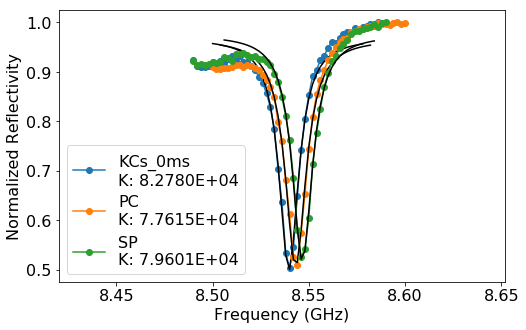

In [26]:
fps_sw = {}

fps_sw['KCs_0ms'] = fps['KCs'] + "Sweep_0ms_exp.csv"
fps_sw['PC'] = fps['PC'] + "Sweep_0ms_exp.csv"
fps_sw['SP'] = fps['SP'] + "Sweep_0ms_exp.csv"

# fps_sw['KCs_0ms_after'] = defaultpath + "Sample KCs/Sweep_0ms_afterZ_exp.csv"

swps = []
swps_V = []
maxV = {}

for samp in fps_sw:  
    if samp == 'KCs_0ms':
        df = pd.read_csv(fps_sw[samp],index_col=False)
        df = df.set_index(df['f(Ghz)'])
        swps.append(df['Experimental R'])
        swps_V.append(df[' Vsignal(V)'])
        maxV[samp] = df[' Vsignal(V)'].max()
    
    else:
        df = pd.read_csv(fps_sw[samp], index_col = 0, skiprows = 4)
        swps.append(df['Reflectivity'])
        maxV[samp] = 0.12
    
    
swps = dict(zip(fps_sw.keys(),swps))
swps_V = dict(zip(fps_sw.keys(),swps_V))

back_V_fit = {} #Forgot to copy values sometimes, so using the Vsignal max value and R0 to estimate background voltage
K = {}

fig, ax = plt.subplots(1,figsize = (8,5))
for sample in swps:
    sweep = swps[sample]
    
    p0 =[sweep.argmin(),1e7,.5 ,1]
    fit_func, popt, sl = fit_lor(sweep, p0, window = 20)
#     fit_func, popt, sl = fit_poly(sweep, window = 3)

    K[sample] = analysis.calc_K(f0 = popt[0], w = popt[1], R0 = popt[2], printparams = False)
    back_V_fit[sample] = -maxV[sample]*popt[2]
    
    ax.plot(sweep, marker = 'o', label = (sample + "\nK: " + str("{:0.4E}".format(K[sample]))))
    ax.plot(sweep.index.values[sl],fit_func[sl] , color = 'black')
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('Normalized Reflectivity')
ax.legend()
ax.xaxis.get_offset_text().set_visible(False)
ax.set_xlim(8.42e9,8.652e9)

In [86]:
ffpath = os.path.join(fps['KCs'],'FreqFluence')
folders = os.listdir(ffpath)
miarray = []
folder_re = '^(\d+\.\d+)GHz_(.+?)'
file_re = 'FF_Filter=\d+_Fluence=(.+?)_data.csv'

flist = []

for folder in folders:
    m_folder = re.search(folder_re,folder)
    freq = float(m_folder.groups(0)[0])*1e9
    direction = m_folder.groups(0)[1]
    folderpath = os.path.join(ffpath,folder)
    files = os.listdir(folderpath)
    for file in files:
        if file[0] == 'F':
            m_file = re.search(file_re, file)
            fluence = float(m_file.groups(0)[0])
            
            fp = os.path.join(folderpath,file)
            
            miarray.append((direction,freq,fluence))
            flist.append(fp)

In [92]:
len(time_arr)

10000

In [87]:
mi = pd.MultiIndex.from_tuples(miarray)

time_arr = load.load_trace(flist[0]).index.values
miarray_t = []
for tup in mi:
    for time in time_arr:
        miarray_t.append((*tup,time))
        
mi_t = pd.MultiIndex.from_tuples(miarray_t, names = ['Direction','Frequency','Fluence','Time'])

s_files = pd.Series(flist, index = mi)


In [99]:

direcs = set(s_files.index.levels[0])
freqs = set(s_files.index.levels[1])
fluences = set(s_files.index.levels[2])


data = np.zeros([len(direcs)*len(freqs)*len(fluences),len(time_arr)])


lowpow = mi.levels[2][-1]

backvs = []
re_backV = "^Background Voltage,-(\d+\.\d+)(.)V"
re_backV2 = "^Background Voltage,-(\d+)(.)V"

lp = 0

for i, tup in enumerate(mi):
    direc, freq, fluence = tup
    fp = s_files[direc,freq,fluence]
    if(fluence == lowpow):
        lp = load.load_trace(fp,50e-9).values
#         print(len(lp))
        data[i,:] = lp - lp
    else:
        d = load.load_trace(fp,50e-9).values
        
        data[i,:] = d - lp
        
    with open(fp) as p:
        for i, line in enumerate(p):
            if i == 11:
                m = re.search(re_backV,line)
                if m == None:
                    m = re.search(re_backV2,line)
                
                if m.groups()[1] == 'm':
                    fac = 1e-3
                elif m.groups()[1] == 'µ':
                    fac = 1e-6
                    
                
                backvs.append(float(m.groups()[0])*fac)
            
data = data.flatten()

s = pd.Series(data,index = mi_t)

backvs = pd.Series(backvs,index = mi).xs(mi.levels[2][-1],level =2)

In [106]:
s

Direction  Frequency     Fluence       Time        
U          8.558000e+09  7.222000e+08  0.000000e+00    2.420817e-07
                                       2.000000e-10    2.577765e-07
                                       4.000000e-10    2.028446e-07
                                       6.000000e-10    1.636076e-07
                                       8.000000e-10    2.028446e-07
                                       1.000000e-09    1.949972e-07
                                       1.200000e-09    2.499291e-07
                                       1.400000e-09    3.048610e-07
                                       1.600000e-09    3.754877e-07
                                       1.800000e-09    4.304196e-07
                                       2.000000e-09    3.597929e-07
                                       2.200000e-09    3.597929e-07
                                       2.400000e-09    2.970136e-07
                                       2.600000e-09    3.362506e

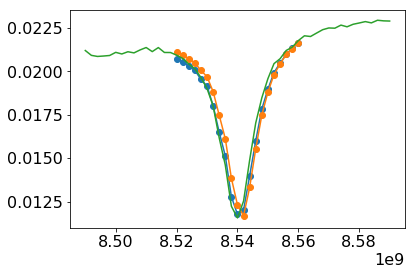

In [100]:
plt.plot(backvs.xs('U').sort_index(level = 1),marker = 'o')
plt.plot(backvs.xs('D').sort_index(level = 1),marker = 'o')
plt.plot(swps_V['KCs_0ms'])

In [110]:
s2

Frequency     Time        
8.520000e+09  0.000000e+00    7.271994e-07
              2.000000e-10    2.414073e-07
              4.000000e-10    2.600916e-07
              6.000000e-10    2.600916e-07
              8.000000e-10    7.739102e-07
              1.000000e-09    8.486474e-07
              1.200000e-09    2.414073e-07
              1.400000e-09    2.694337e-07
              1.600000e-09    7.178573e-07
              1.800000e-09   -3.284643e-07
              2.000000e-09    7.178573e-07
              2.200000e-09    7.552259e-07
              2.400000e-09    7.178573e-07
              2.600000e-09    8.393053e-07
              2.800000e-09    9.607533e-07
              3.000000e-09    1.026148e-06
              3.200000e-09    3.587984e-08
              3.400000e-09    4.562769e-07
              3.600000e-09    3.254867e-07
              3.800000e-09    6.618043e-07
              4.000000e-09    5.683828e-07
              4.200000e-09   -1.322790e-07
              4.400000e-09 

(2e-07, 7e-07)

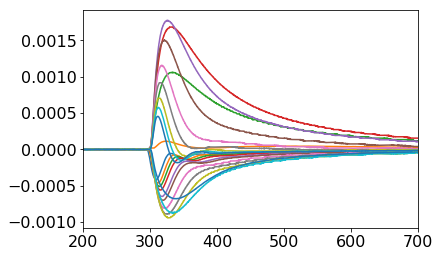

In [109]:
s1 = s.xs('U',level = 0).sort_index(level = 0)
fluences = s1.index.levels[1]
s2 = s1.xs(fluences[1],level = 1).sort_index(level = 0)
freqs = s2.index.levels[0]
fig, ax = plt.subplots()

for freq in freqs:
    ax.plot(s2[freq])
    
ax.xaxis.set_major_formatter(FuncFormatter(exp_formatter(-9).format_func))
ax.set_xlim([200e-9,700e-9])

In [111]:
timesel = 375e-9

dv = s2.xs(timesel,level = 1)
v0 = backvs.xs('U').sort_index(level = 1)
vs = v0 + dv

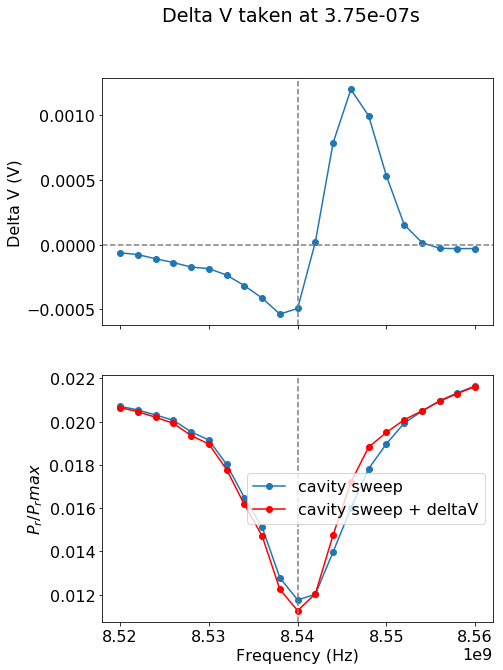

In [112]:
fig, axes = plt.subplots(2,1, figsize = (7,10), sharex = True)

axes[0].plot(dv, marker = 'o')

axes[1].plot(v0, label = 'cavity sweep', marker = 'o')
# axes[1].plot(freq_i,fit_swp, label = 'cavity sweep fit')
axes[1].plot(vs, color = 'r', label = 'cavity sweep + deltaV' ,  marker = 'o')
# axes[1].plot(freq_i,fit_shift, label = 'cavity sweep + deltaV fit')

axes[1].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
axes[0].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
axes[0].axhline(0, color = 'gray', linestyle = '--')

axes[0].set_ylabel('Delta V (V)')
axes[1].set_ylabel('$P_r/P_rmax$')
axes[1].set_xlabel('Frequency (Hz)')

# axes[1].set_xlim([8.525e9,8.545e9])
# axes[1].set_ylim([0.4,0.8])

fig.suptitle('Delta V taken at ' + str(timesel) + 's')


plt.legend()

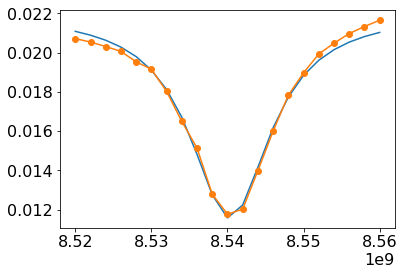

In [113]:
timesel = 450e-9

v0 = backvs.xs('U').sort_index(level = 1)

dv = s2.xs(timesel,level = 1)

vs = v0 + dv

# timesel = min(cuttimes, key=lambda x:abs(x-timesel))

Rinf = 0.02125
p0 =[v0.idxmin(),1e7,0.01, Rinf]
epsilon = 0.1

window = 10

p_labels = ['f0','Q','R','Rinf']
v0_fit, v0_p, v0_sl = fit_lor(v0, p0,bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon]), window = window)
v0_fit = pd.Series(v0_fit, index = v0.index)
v0_p = pd.Series(v0_p, index = p_labels)


plt.plot(v0_fit)
plt.plot(v0, marker = 'o')

In [171]:
for cuttime in cuttimes:
    deltaV_i = pd.Series(np.interp(freq_i,df_deltaV.loc[cuttime].index,df_deltaV.loc[cuttime]), index = freq_i)
    df_deltaV_i.loc[cuttime] = deltaV_i
    
    swpV_shift_i = swpV_i+deltaV_i
    df_swpV_shift_i.loc[cuttime] = swpV_shift_i


    fit_swp_shift, popt_swp, sl = fit_lor(swpV_shift_i, p0,bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon]), window = window)
    df_fits.loc[cuttime] = fit_swp_shift
    df_params.loc[cuttime] = popt_swp

# #     fit_func_swp, popt_swp, sl = fit_poly(swpV_i_norm, window = 100)
# #     fit_func_new, popt_new, sl_new = fit_poly(swpnew_norm, window = 10)

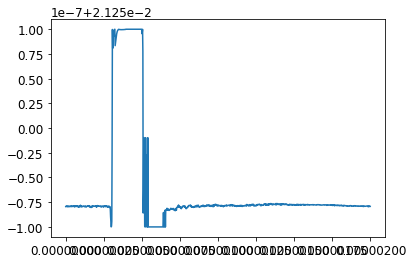

In [153]:
plt.plot(df_params['Rinf'])

79490.94935167805


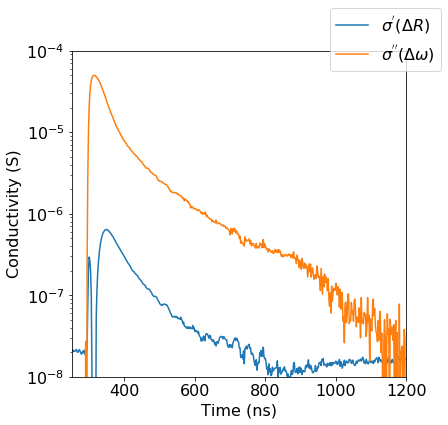

In [173]:
fig, axes = plt.subplots(1,1, figsize = (6,6), sharex = True)

deltaR = df_params['R']- p_swp['R']
# K = trmc.calc_K(p_swp['f0'],p_swp['Q'],p_swp['R']) #doesn't work with mV
print(K['A_1000ms'])
sig_R = (1/K['A_1000ms'])*(deltaR/p_swp['R'])

deltaf = df_params['f0']- p_swp['f0']
e0 = 8.854e-12
F=1
sig_I = 2*deltaf*e0/F

axes.plot(sig_R, label = '$\sigma^{\'}(\Delta R)$')
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$')
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.set_xlim(250e-9,1200e-9)

fmt = exp_formatter(-9)
axes.xaxis.set_major_formatter(FuncFormatter(fmt.format_func))
axes.set_xlabel('Time (ns)')
# for ax in axes:
axes.set_ylim([1e-8,1e-4])
fig.legend()

(2.5e-07, 7e-07)

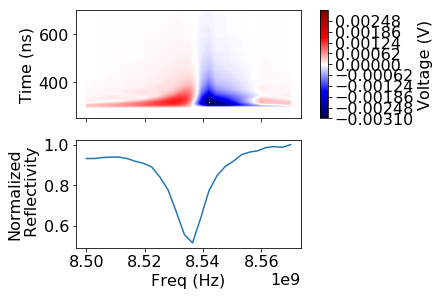

In [174]:
x = df_deltaV.columns.values
y = df_deltaV.index.values
z = df_deltaV.values

levels = list(np.arange(-3.1e-3,3.1e-3,1e-5))

xi, yi = np.meshgrid(x,y)

fig , axes = plt.subplots(2,1 , sharex = True,constrained_layout=True)

cs = axes[0].contourf(xi,yi,z, levels, cmap='seismic')
cb = fig.colorbar(cs, ax = axes[0])


expf = exp_formatter(-9)
axes[0].yaxis.set_major_formatter(FuncFormatter(expf.format_func))
axes[0].set_ylabel('Time (ns)')
axes[1].set_xlabel('Freq (Hz)')
axes[1].set_ylabel('Normalized\n Reflectivity')
cb.set_label('Voltage (V)')

axes[1].plot(sweep)

axes[0].set_ylim([2.5e-7,0.7e-6])
# axes[0].set_xlim([8.535e9,8.545e9])

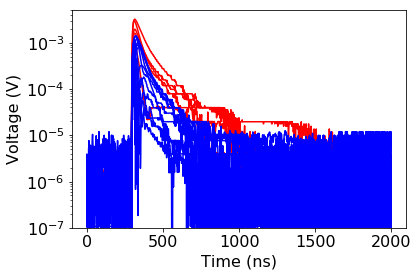

In [175]:
fig, ax = plt.subplots()

for column in df_deltaV.columns:
    trace = df_deltaV[column]
    if len(trace.shape) == 1:
#         print(np.trapz(trace))
        if np.trapz(trace) > 0:
            color = 'b'
            zorder = 2
        else:
            color = 'r'
            zorder = 1
        ax.plot(abs(trace), color = color, zorder = zorder )
        

ax.set_yscale('log')
ax.set_ylim([1e-7,5e-3])
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (ns)')

expf = exp_formatter(-9)
ax.xaxis.set_major_formatter(FuncFormatter(expf.format_func))

In [176]:
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

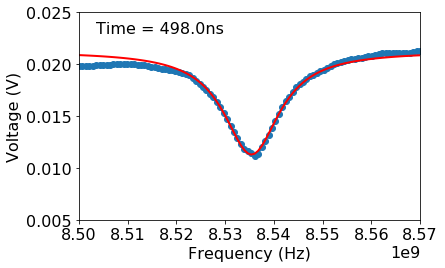

In [177]:
timesel1 = 250e-9
timesel2 = 500e-9

idx1 = abs(df_swpV_shift_i.index - timesel1).argmin()
idx2 = abs(df_swpV_shift_i.index - timesel2).argmin()

RawData_Frames = df_swpV_shift_i.iloc[idx1:idx2]
RawData_Frames_fit = df_fits.iloc[idx1:idx2]
timeindex = RawData_Frames.index*1e9
interval = 50
xs = RawData_Frames.columns.values



# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(xs[0], xs[-1]), ylim = (0.005,0.025))

line, = ax.plot([], [], lw=2, marker = 'o')
line_fit, = ax.plot([], [], lw=2, color = 'r')

time_template = 'Time = %.1fns'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

fig.tight_layout()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line_fit.set_data([], [])
    time_text.set_text('')
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Frequency (Hz)") 
    return line,line_fit

# animation function.  This is called sequentially
def animate(i):
    line.set_data(xs, RawData_Frames.iloc[i].values)
    line_fit.set_data(xs, RawData_Frames_fit.iloc[i].values)
    time_text.set_text(time_template % timeindex[i])
    return line, time_text



# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(timeindex), interval = interval, blit=True)


# TML(anim.to_html5_video())

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

anim


In [120]:
df_swpV_shift_i.index

Float64Index([                   0.0,                  2e-09,
                               4e-09,                  6e-09,
                               8e-09,                  1e-08,
                             1.2e-08,                1.4e-08,
                             1.6e-08,                1.8e-08,
              ...
                            1.98e-06,              1.982e-06,
                           1.984e-06,              1.986e-06,
              1.9880000000000003e-06,               1.99e-06,
              1.9919999999999997e-06,              1.994e-06,
                           1.996e-06,              1.998e-06],
             dtype='float64', name='Time(s)', length=1000)